# Efektywna rekonstrukcja zdjęć kotów za pomocą wariacyjnych autoenkoderów z pomocą Self Supervised Learning

## 1. Wprowadzenie

### 1.1 Opis problemu

Celem projektu jest wytrenowanie modeli probabilistycznych autoenkoderów do rekonstrukcji obrazów kotów, które zostały częściowo zakryte maskami. Problem ten wpisuje się w obszar uczenia reprezentacji oraz probabilistycznych modeli grafowych. Zastosowane modele 

- VAE - baseline
- VQ-VAE
- VAE z priorem Tree-Vi 
- Attention-VAE

które mają nauczyć się skutecznego odwzorowywania struktury obrazu nawet w warunkach brakujących danych wejściowych.

Projekt opiera się na założeniu, że jakościowe reprezentacje ukryte, nauczone w sposób probabilistyczny, mogą posłużyć do efektywnej rekonstrukcji obrazów z brakującą informacją. 

W celu rozszerzenia projektu badamy, czy techniki uczenia samonadzorowanego, takie jak 

- BYOL
- Barlow Twins 
- SimCLR

mogą dodatkowo poprawić jakość enkoderów używanych w autoenkoderach. Zostaną one zastosowane z opcją zamrożenia wag wstępnie wytrenowanych enkoderów.

### 1.2 Opis danych wejściowych

Danymi wejściowymi są kolorowe obrazy kotów pochodzące z publicznego zbioru [Cats Image Dataset](https://www.kaggle.com/datasets/mahmudulhaqueshawon/cat-image/data). Obrazy przedstawiają pojedyncze twarze kotów oraz są w rozmiarze 3x64x64 pikseli.

Dane wejściowe zostaną poddane procesowi ETL oraz preprocesingu obejmującemu normalizację i przeskalowanie obrazów do jednolitego rozmiaru.

Podczas treningu wariacyjnych autoenkoderów przeprowadza się dynamiczną augmentację w postaci losowego nakładania masek o losowych rozmiarach w losowych miejscach, sparametryzowanych odpowiednimi ograniczeniami.

Dla zbioru validacyjnego i testowego obrazy posiadają wcześniej wygenerowane maski, aby uzyskać miarodajne wyniki.

w przypadku trenowania modeli SSL augumentacje są zależne od konkretnej metody oraz zostaną opisane w odpowiednich sekcjach.

### 1.3 Opis danych wyjściowych

Danymi wyjściowymi modeli są rekonstrukcje pełnych obrazów kotów bez maski z prawidłowym uzupełnieniem. Oczekujemy, że modele autoenkoderów nauczą się odwzorowywać brakujące fragmenty zdjęcia na podstawie informacji zawartych w reprezentacji ukrtytej.

### 1.4 Hipoteza badawcza

1. Zastosowanie probabilistycznych autoenkoderów umożliwia skuteczną rekonstrukcję obrazów kotów, które zostały częściowo zakryte maską.
2. Wstępne przetrenowanie enkoderów przy użyciu metod SSL dodatkowo poprawia jakość otrzymywanych rekonstrukcji.

Zakładamy, że różne podejścia do modelowania przestrzeni ukrytej (VQ, Tree priors) oraz różne techniki samonadzorowanego uczenia wpływają w zauważalny sposób na jakość reprezentacji i końcową skuteczność rekonstrukcji. Badanie to umożliwi określenie, który wariacyjny autoenkoder oraz technika SSL daje najlepsze rezultaty w kontekście rekonstrukcji obrazów kotów.

## 2. Opis wybranych modeli oraz metod

### 2.1 Wariacyjne autoenkodery

#### 2.1.1 VAE - Variational Autoencoder

Podstawowym modelem na którym oparte są pozostałe warianty jest klasyczny wariacyjny autoenkoder (VAE) pochodzący z pracy [Diederik P Kingma, Max Welling, 2013](https://arxiv.org/abs/1312.6114).

VAE to probabilistyczny autoenkoder, który zamiast kodować dane wejściowe do jednej reprezentacji wektorowej, uczy rozkład prawdopodobieństwa w przestrzeni latentnej. Podczas uczenia model maksymalizuje ELBO. Reprezentacja ukryta jest próbkowana z rozkładu normalnego (parametryzowanego przez enkoder), a dekoder rekonstruuje obraz.
<p align="center">
  <img src="./assets/vae-scheme.png" width="600">
</p>

<p align="center"><i>Schemat klasycznego VAE (źródło: <a href="https://medium.com/@jimwang3589/variational-autoencoder-vae-7609893c80f4">Medium</a>)</i></p>


Komponenty VAE:
- **Enkoder**: w naszym przypadku sieć konwolucyjna, której zadaniem jest zakodowanie danych wejściowych do skompresowanej reprezentacji, minimalizując utratę istotnej informacji z obrazu.

- **Warstwa probabilistyczna**: 
    - Przyjmuje reprezentację latentną z enkodera i przekształca ją do dwóch wektorów: średniej $\mu$ oraz logarytmu wariancji $\log(\sigma^2)$ za pomocą dwóch oddzielnych warstw liniowych.
    - Reparametryzacja ($\epsilon \sim \mathcal{N}(0, I) $): umożliwia propagację gradientu przez warstwę probabilistyczną $z = \mu + \sigma \cdot \epsilon$.
    - Zmienna latentna ($z$): próbkowana z rozkładu normalnego $\mathcal{N}(\mu, \sigma^2)$, z którego odtwarzane są dane przez dekoder.

- **Dekoder**: za pomocą transponowanych warstw konwolucyjnych rekonstruuje oryginalny obraz z wektora latentnego $z$.

- **Funkcja straty**: suma błędu rekonstrukcji (MSE) i dywergencji KL między rozkładem ukrytym, a prior'em będącym rozkładem normalnym $\mathcal{N}(0, I)$.


$$\mathcal{L}_{\text{VAE}} = \text{MSE}(x, \hat{x}) + D_{\text{KL}}\left( q(z|x) \,\|\, p(z) \right)$$

#### 2.1.2 VQ-VAE - Vector Quantized Variational Autoencoder

VQ-VAE to wariant VAE, w którym przestrzeń latentna jest dyskretna. Oznacza to, że składa się ze skończonego słownika - codebook wektorów. (przykładowo słownik 128 wektorów, każdy zawierający 64 ciągłych wartości) Enkoder przypisuje dane wejściowe do najbliższego wektora w słowniku, a dekoder rekonstruuje dane na podstawie tej zakodowanej reprezentacji. Uczenie odbywa się z użyciem specjalnej straty łączącej MSE i różnicę między zakodowaną reprezentacją a najbliższym wektorem ze słownika. [Aaron van den Oord, Oriol Vinyals, Koray Kavukcuoglu, 2017](https://arxiv.org/abs/1711.00937).

<p align="center">
  <img src="./assets/vqvae-scheme.png" width="700">
</p>

<p align="center"><i>Schemat VQVAE (źródło: <a href="https://arxiv.org/pdf/1711.00937">arxiv</a>)</i></p>


- **Enkoder:** mapuje wejściowy obraz $x$ na ciągłą reprezentację latentną $z_e(x) \in \mathbb{R}^D$.

- **Codebook (embedding space):** zawiera $K$ wektorów. Reprezentacja $z_e(x)$ jest kwantyzowana do najbliższego wektora $z_q(x) = e_k$

- **Dekoder:** odtwarza obraz $\hat{x}$ z zakodowanej i skwantyzowanej reprezentacji $z_q(x)$.

- **Funkcja Straty (Straight-through Estimator):** gradienty przechodzą bezpośrednio przez $z_q \rightarrow z_e$.


$$
\mathcal{L}_{\text{VQ-VAE}} = \underbrace{\| x - \hat{x} \|_2^2}_{\text{rekonstrukcja}} 
+ \underbrace{\| \text{sg}[z_e(x)] - e \|_2^2}_{\text{VQ loss}} 
+ \beta \underbrace{\| z_e(x) - \text{sg}[e] \|_2^2}_{\text{commitment loss}}
$$

Gdzie:
- $\text{sg}[\,\cdot\,]$ to operator *stop-gradient* (brak propagacji wstecz),
- $e$ to najbliższy wektor codebooku dla $z_e(x)$,
- $\beta$ to waga terminu commitment loss.


#### 2.1.3 VAE + Tree VI - Variational Autoencoder with Tree Variational Inference

TreeVI (Tree-structured Variational Inference) to metoda inferencji wariacyjnej, która modeluje korelacje między zmiennymi ukrytymi za pomocą struktury drzewa. W przeciwieństwie do klasycznego podejścia mean-field, które zakłada niezależność zmiennych ukrytych, TreeVI pozwala na uchwycenie zależności wyższego rzędu między tymi zmiennymi.

Dla zbioru zmiennych ukrytych $\{z_i\}_{i=1}^N$​, TreeVI zakłada, że ich wspólne rozkłady są modelowane przez strukturę drzewa $T=(V,E)$, gdzie V to węzły odpowiadające zmiennym ukrytym, a E to krawędzie reprezentujące bezpośrednie zależności między nimi.

Dla każdej pary zmiennych ukrytych $(z_i,z_j)$), korelacja $ \widetilde{\gamma}_{ij} $ jest definiowana jako iloczyn korelacji wzdłuż ścieżki $P_{i->j}$​ w drzewie:

$$ \widetilde{\gamma}_{ij} = \prod_{(s,t) \in P_{i -> j}} \gamma_{st}$$

gdzie $\gamma_{st}$ to korelacja między bezpośrednio połączonymi zmiennymi $z_s$​ i $z_t$​.

##### Reparametryzacja

TreeVI umożliwia efektywną reparametryzację próbek z rozkładu posteriori poprzez próbki z rozkładu normalnego i zastosowanie transformacji zależnych od struktury drzewa, co pozwala na równoległe i skalowalne uczenie modelu.

##### Funkcja straty

TreeVI rozszerza klasyczny VAE poprzez wprowadzenie dynamicznej struktury grafowej między próbkami w partii danych, co pozwala na modelowanie zależności między instancjami.

Modyfikacje wprowadzone w TreeVI:

Dynamiczna struktura grafowa: Zamiast zakładać niezależność próbek, TreeVI buduje graf, w którym wierzchołki reprezentują próbki, a krawędzie modelują ich zależności. Struktura grafu jest optymalizowana za pomocą algorytmu Kruskala na podstawie przewidywanych wag krawędzi.

Wektor propagacji v: Wektor latentny jest modyfikowany przez wektor propagacji v, który uwzględnia strukturę grafu oraz znaczenie poszczególnych wymiarów latentnych.

Znaczenie wymiarów latentnych: Wprowadzono mechanizm oceny znaczenia poszczególnych wymiarów latentnych za pomocą GNN, co pozwala na dynamiczne ważenie tych wymiarów podczas dekodowania.

Funkcja straty dla TreeVI:

$$ L_{TreeVI​(x)}= − E_{q(z∣x)}​[log_p(x∣z)] + D_{KL}​(q(z∣x)∥p(z)) + \lambda L_{graph​} $$

Gdzie:

$L_{graph​}$ – dodatkowy składnik funkcji straty uwzględniający jakość struktury grafu (np. różnica między przewidywaną a rzeczywistą strukturą),

$\lambda$ – współczynnik regularyzacji dla składnika grafowego.

---

##### Funkcja straty w PyGTreeVAE

Poniżej prezentuję szczegółowe wyprowadzenie funkcji straty (ujemnego ELBO) w modelu **PyGTreeVAE**, z zachowaniem oznaczeń i struktury wykorzystanych w poprzednich opisach.

- Dane wejściowe: $x\in\mathbb{R}^{B\times D_{\text{input}}}$  
- Przestrzeń ukryta (latenty): wymiar \(D$  
- Enkoder VAE daje:
  $$
  \mu = \mu(x)\in\mathbb{R}^{B\times D}, \quad
  \sigma = \sigma(x)\in\mathbb{R}^{B\times D}, \quad
  q(z|x)=\mathcal{N}\bigl(\mu,\;\mathrm{diag}(\sigma^2)\bigr).
  $$
- Budujemy:
  1. Drzewo instancji: $\text{edge\_index}$ i korelacje $\gamma_{ij}$ przez GNN‐optymalizator.
  2. GNN‐instancji:  
     $$
     v_{\text{inst}} = \mathrm{GNN}_{\text{inst}}(\mu,\,\text{edge\_index}) \;\in\mathbb{R}^{B\times D}.
     $$
  3. GNN‐wymiarów („Dim‐GNN”):  
     $$
     \alpha = \mathrm{GNN}_{\text{dim}}(\text{dim\_embeddings},\,\text{edge\_index}_{\!\text{dim}})\;\in\mathbb{R}^{D},
     $$
     gdzie $\alpha[d]$ to tzw. **dim\_importance** dla wymiaru $d$.

- Reparametryzacja:  
  $$
  \epsilon \sim \mathcal{N}(0,\,I_{B\times D}), 
  \quad 
  v = v_{\text{inst}} \odot \alpha, 
  \quad
  z = \mu + \sigma \odot v.
  $$
  Tutaj „$\odot$” to mnożenie element–po–elemencie; w praktyce $\alpha\in\mathbb{R}^D$ jest broadcastowane do wymiaru $B\times D$.

- Dekoder VAE: $p(x|z)$. Zakładamy, że  
  $$
  \log p(x|z) \approx -\tfrac{1}{2\,\sigma_x^2}\,\lVert x - f_\theta(z)\rVert^2 + \text{const},
  $$
  co dla uproszczenia zastępujemy jednym termem $-\mathrm{MSE}(f_\theta(z),\,x)$.

---

#### 2. Definicja ELBO w PyGTreeVAE

Ogólnie, tak jak w klasycznym VAE, minimalizujemy **ujemne ELBO**:

$$
\mathcal{L}_{\text{ELBO}} \;=\; -\,\mathbb{E}_{q(z|x)}\bigl[\log p(x|z)\bigr] 
\;+\; D_{\mathrm{KL}}\!\bigl(q(z|x)\,\Vert\,p(z)\bigr).
$$

W przypadku PyGTreeVAE mamy dokładnie tę samą formę, tylko $z$ jest teraz funkcją $\mu,\sigma,v_{\text{inst}},\alpha$. Rozpiszmy każdy składnik.

---

#### 2.1. Składnik rekonstrukcji

Dla pojedynczej próbki $x^{(i)}$ w partii ($i=1,\dots,B$):

1. Generujemy latent $z^{(i)}$ przez
   $$
   v_{\text{inst}}^{(i)} \;=\; \bigl[\mathrm{InstanceGNN}(\mu,\text{edge\_index})\bigr]_i, 
   \quad
   v^{(i)} = v_{\text{inst}}^{(i)} \odot \alpha, 
   \quad
   z^{(i)} = \mu^{(i)} + \sigma^{(i)} \odot v^{(i)}.
   $$
2. Dekoder daje rekonstrukcję $\hat x^{(i)} = f_\theta\bigl(z^{(i)}\bigr)$.
3. Zakładamy MSE‐loss (lub log‐gaussian):

   $$
   -\,\mathbb{E}_{q(z|x)}\bigl[\log p(x|z)\bigr]
   \;\approx\;
   \sum_{i=1}^B \frac{1}{2\,\sigma_x^2}\,\bigl\lVert x^{(i)} - \hat x^{(i)}\bigr\rVert^2
   \;\propto\;
   \mathrm{MSE}\bigl(f_\theta(z),\,x\bigr).
   $$

W implementacji uprościliśmy to do:

$$
\mathcal{L}_{\text{rec}} = \sum_{i=1}^B \lVert \hat x^{(i)} - x^{(i)}\rVert^2.
$$

---

#### 2.2. Składnik KL–dywergencji

Mamy przyjęte:

- $q(z|x^{(i)}) = \mathcal{N}\bigl(\mu^{(i)},\,\mathrm{diag}\bigl((\sigma^{(i)})^2\bigr)\bigr)$.
- $p(z) = \mathcal{N}(0, I)$.

Wtedy:

$$
D_{\mathrm{KL}}\!\bigl(q(z|x^{(i)}) \;\Vert\; p(z)\bigr)
= \frac{1}{2}\sum_{d=1}^D \Bigl[
   \bigl(\mu^{(i)}_d\bigr)^2 + \bigl(\sigma^{(i)}_d\bigr)^2 
   - \log\Bigl(\bigl(\sigma^{(i)}_d\bigr)^2\Bigr) - 1
\Bigr].
$$

Dla całej partii:

$$
\mathcal{L}_{\mathrm{KL}} 
= \sum_{i=1}^B \;D_{\mathrm{KL}}\!\bigl(q(z|x^{(i)}) \Vert p(z)\bigr).
$$

---

#### Całkowite ujemne ELBO

Zatem końcowa funkcja straty (minimalizowana podczas treningu) to:

$$
\boxed{
\mathcal{L}_{\text{PyGTreeVAE}} 
= \underbrace{\sum_{i=1}^B \lVert\,x^{(i)} - f_\theta(z^{(i)})\,\rVert^2}_{\mathcal{L}_{\text{rec}}}
\;+\; 
\underbrace{\sum_{i=1}^B 
  \frac{1}{2}\sum_{d=1}^D 
    \Bigl[\bigl(\mu^{(i)}_d\bigr)^2 + \bigl(\sigma^{(i)}_d\bigr)^2 
    - \log\bigl((\sigma^{(i)}_d)^2\bigr) - 1 \Bigr]
}_{\mathcal{L}_{\mathrm{KL}}}\;.
}
$$

- **Istotne**:  
  – tu nie wprowadzamy dodatkowego terminu regularyzującego bezpośrednio strukturę drzewa ani wymiary latentne – ich optymalizacja odbywa się _wbudowanie_ w sieci GNN (poprzez backpropagację gradientu z powyższego $\mathcal{L}$ w stosunku do wag GNN).  
  – W związku z tym „koszt utworzenia / zmiany MST” (np. Kruskal) nie pojawia się jawnie w funkcji straty, lecz jest traktowany jako „dziura gradientowa” (discrete step). Dla spełnienia gradientowej spójności cała sieć GNN otrzymuje sygnał z $\mathcal{L}$.


- **Podsumowując**:  
  – W każdym z trzech modeli ELBO ma tę samą formę (rekonstrukcja + dywergencja KL).  
  – Różnica leży w **sposobie generowania** próbek $z$:  
    1. **VAE**: $z = \mu + \sigma\odot\epsilon$.  
    2. **TreeVI**: $z = \mu + \mathrm{Cholesky}(\Sigma)\,\epsilon$, gdzie $\Sigma$ zależy od drzewa.  
    3. **PyGTreeVAE**: $z = \mu + \sigma \odot (v_{\text{inst}}\odot \alpha)$, gdzie  
       - $v_{\text{inst}}$ z GNN‐instancji wg bieżącego drzewa,  
       - $\alpha$ = dim_importance z GNN wymiarów latentnych.  
  – W **PyGTreeVAE** optymalizacja struktury drzewa i wagi wymiarów jest wbudowana w backprop, natomiast w TreeVI używa się L‐BFGS + dyskretne MST.  
  – Rezultat: **PyGTreeVAE** pozwala uczyć zarówno hierarchię korelacji między próbkami, jak i ważność poszczególnych wymiarów latentnych, w jednym przejściu treningowym. 


| Kryterium                                 | VAE                                                                                       | TreeVI                                                                                                           | PyGTreeVAE                                                                                                                                    |
|-------------------------------------------|-------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|
| **Posterior $(q(z \| x))$**                    | Mean‐field Gaussian: <br> $q(z \| x) = \mathcal{N}(\mu, \, \mathrm{diag}(\sigma^2))$.      | Wielowymiarowa Gaussowska z kowariancją wynikającą z drzewa: <br> $\Sigma = \mathrm{diag}(\sigma)\,R\,\mathrm{diag}(\sigma)$, gdzie $R$ jest macierzą korelacji z drzewa. | Analogicznie do TreeVI, ale drzewo jest dynamicznie optymalizowane przez GNN. Kowariancja bierze pod uwagę zarówno strukturę drzewa, jak i znaczenie wymiarów latentnych. |
| **Struktura korelacji między próbkami**   | Brak: założenie niezależności próbek w przestrzeni latentnej.                              | Statyczne drzewo inicjalizowane (np. łańcuch) i optymalizowane metodą L‐BFGS nad γ.                             | Dynamiczne drzewo generowane przez GNN: <br> – najpierw GCNConv nad μ → ocena “score” krawędzi, <br> – Kruskal → nowe MST, <br> – γ prognozowane przez MLP.            |
| **Reparametryzacja $z$**                | $z = \mu + \sigma \odot \epsilon$, <br> $\epsilon \sim \mathcal{N}(0, I)$.             | $z = \mu + \mathrm{Cholesky}(\Sigma)\,\epsilon$, <br> gdzie $\mathrm{Cholesky}(\Sigma)$ uwzględnia drzewo.   | $z = \mu + \sigma \odot (v_{\text{inst}} \odot \alpha)$, <br>   – $v_{\text{inst}}$ z GNN instancji, <br> – $\alpha$ = dim_importance z GNN wymiarów latentnych. |
| **Uczenie struktury drzewa**              | Nie dotyczy – bez struktury drzewiastej.                                                  | Optymalizacja macierzy wag $W$ i wektorów $\gamma$ przez L‐BFGS (augmented Lagrangian), <br> następie MST.   | Uczenie end‐to‐end: <br> – GCNConv nad $\mu$ → wektory $h$, <br> – MLP “score” dla każdej pary → Kruskal → nowe drzewo, <br> – MLP “γ” dla każdej krawędzi.         |
| **Ocena znaczenia wymiarów latentnych**   | Brak: wszystkie wymiary traktowane równomiernie.                                           | Brak – każdy wymiar traktowany analogicznie w reparametryzacji Cholesky’ego.                                     | GNN nad wymiarami latentnymi: <br> – uczony $\mathrm{dim\_adj\_logits}$ → edge_index_dim, <br> – GCNConv → `dim_importance[d]` dla każdego wymiaru.                      |
| **Elastyczność topologii**                | Brak – nie ma topologii.                                                                  | Ograniczona do drzewa; każdy batch wymaga rekonstrukcji i optymalizacji γ, <br> algorytm L‐BFGS kosztowny.         | Dowolna topologia: <br> – można łatwo zmienić warstwy GNN (GraphSAGE, GAT itp.), <br> – operacje na edge_index są zoptymalizowane dla GPU.                           |
| **Koszt obliczeniowy**                    | $O(B \times D)$ (encoder + decoder).                                                     | $O(B^2 \times D)$ (budowa/kopalna Cholesky’ego + L‐BFGS na macierzy $W \in \mathbb{R}^{B \times B}$).        | $O(E \times D)$ dla GCNConv instancji (gdzie $E \approx B$ w drzewie), <br> $O(B^2 \times D)$ dla MST (Kruskala) nad prognozowanymi skórami, <br> reszta na GPU. |
| **Interpretowalność**                     | Wymiary latentne nie mają globalnej struktury – trudno interpretować zależności.          | Struktura drzewa może być interpretowana hierarchicznie; jednak γ nie zawsze intuicyjne.                        | Struktury są “widoczne” jako graf: <br> – interpretacja MST nad $\mu$, <br> – `dim_importance` pokazuje które wymiary są najważniejsze.                                |
| **Potencjał skalowania**                  | Dobrze skaluje się do dużych $B$.                                                        | Słabo skaluje: optymalizacja L‐BFGS nad $B \times B$ przy dużym $B$ jest kosztowna.                         | Lepsze skalowanie dzięki: <br> – GNN na instancjach w $O(E)$, <br> – zoptymalizowane sparse operacje w PyG, <br> – jednorazowy MST (Kruskala) na CPU.                  |


#### 2.1.4 A-VAE / VAE-GAN  - Adversarial Variational Autoencoder

### TODO Daniel

### 2.2 Self Supervised Learning

#### 2.2.1 SimCLR - Simple Framework for Contrastive Learning of Visual Representations

### TODO Daniel
Metoda SimCLR, wprowadzona w pracy [A simple framework for contrastive learning of visual representation](https://arxiv.org/abs/2006.07733), opiera się na transformacji każdego elementu z batcha $x$ z wykorzystaniem dwóch augmentacji ($v_i, v_j $). Następnie dla wszystkich par $(z_{m,i}=v_{i}(x_m), z_{n,j}=v_j(x_n))$ po wszystkich elementach $m,n$ obliczana jest strata $\ell_{i, j}$, karząca wszystkie podobne pary, niebędące reprezentacjami przekształconego tego samego wejścia.

$$  
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(z_i, z_j\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(z_i, z_k\right) / \tau\right)},
$$

#### 2.2.2 BYOL - Bootstrap Your Own Latent

BYOL to metoda uczenia reprezentacji bez użycia etykiet ani kontrastowania negatywnych przykładów. Opiera się na architekturze dwóch
bliźniaczych sieci: online i target. Zadaniem metody jest nauczenie się reprezentacji poprzez minimalizację różnicy między reprezentacjami dwóch różnych augmentacji tego samego obrazu.


[Jean-Bastien Grill, Florian Strub, Florent Altché,... 2020](https://arxiv.org/abs/2006.07733).


<p align="center">
  <img src="./assets/byol-scheme.png" width="700">
</p>

<p align="center"><i>Schemat BYOL (źródło: <a href="https://arxiv.org/pdf/2006.07733">arxiv</a>)</i></p>

- **Dwa widoki obrazu**: $t(x)$ i $t'(x)$ (augmentacje)
- **Online network:** $f_\theta \rightarrow g_\theta \rightarrow q_\theta$
- **Target network:** $f_\xi \rightarrow g_\xi$
- gdzie $f$ to enkoder, $g$ to projektor, a $q$ to predyktor.
- **Funkcja straty:** minimalizuje odległość między predykcją z online i reprezentacją z target:
  
  $$
  \mathcal{L}_{\text{BYOL}} = \| q_\theta(z_\theta) - \text{sg}(z'_\xi) \|_2^2
  $$

Sieć target nie uczy się jak sieć online, jej wagi są aktualizowane na podsatwie wag sieci online z parametrem $\tau$.


#### 2.2.3 Barlow Twins

Barlow Twins to metoda samouczenia się reprezentacji (self-supervised learning), która została zaproponowana jako sposób na uczenie głębokich modeli bez potrzeby etykietowanych danych. Opiera się na porównywaniu dwóch różnych widoków (augmentacji) tego samego obrazu. Przechodzą one przez ten sam encoder, a następnie przez projektor (MLP), który generuje końcowe reprezentacje.

**Funkcja straty to:**

$$ \mathcal{L}_{\text{Barlow Twins}} = \sum_i(1−C_{ii})^2+ \lambda \sum_i \sum_{j≠i}C_{ij}^2$$

Gdzie:
- C to macierz korelacji pomiędzy reprezentacjami dwóch widoków.
- Pierwszy składnik dąży do tego, aby reprezentacje tego samego obrazu były jak najbardziej podobne.
- Drugi składnik (z wagą $\lambda$) karze za redundancję, czyli za korelację między różnymi wymiarami reprezentacji.

[Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/abs/2103.03230).


## 3. Opis eksperymentów

### 3.1 Jak przygotowano zbiór danych?

Eksperymenty wykonano na zbiorze danych dotyczących twarzy kotków: [Cats Image (64*64)](https://www.kaggle.com/datasets/mahmudulhaqueshawon/cat-image).

Dokonywany jest proces ETL, który:
- Pobiera dane wykorzystując API Kaggle 
- Dzieli zdjęcia na zbiór treningowy, walidacyjny oraz testowy - W celu optymalizacji zapisuje json, z informacjami, który numer zdjęcia należy do którego zbioru (nie wymaga kopiowania zdjęć)
- Następnie dochodzi do prostej transformacji na tensorach zdjęć - zostają sprowadzone do jednolitej wielkości oraz znormalizowane

Cały proces kończy się zwróceniem 3 obiektów klasy DataLoader - zbioru treningowego, walidacyjnego i testowego. Cały proces jest zaprojektowany tak, aby nie powtarzać nie potrzebnie operacji - jeśli dane zostały już pobrane to nie zostaną pobrane ponownie. Tak samo dotyczy to podziału danych oraz transformacji.

Aby uruchomić tylko opisany proces ETL wystarczy wpisać:

```
make run_etl
```

### 3.2 Zastosowane metryki

Jakość danych wyjściowych na zbiorze testowym będzie oceniana przy użyciu metryk porównujących obraz zrekonstruowany z obrazem oryginalnym, takich jak:

- PSNR (Peak Signal-to-Noise Ratio)
- SSIM (Structural Similarity Index)
- MSE (Mean Squared Error)
- Wizualna analiza jakości rekonstrukcji

Do wybierania najlepszego modelu spośród tych samych typów zostanie wybrany model z najniższą funkcją straty na zbiorze walidacyjnym.

## 4. Eksperymenty oraz wyniki

### 4.0 Wprowadzenie 

Wszystkie eksperymenty zostały przeprowadzone z wykorzystaniem tej samej architektury enkodera oraz dekodera, aby zapewnić uczciwe i miarodajne porównanie wyników różnych modeli.

#### Architektura enkodera:
- `input_dim`: 3 (obrazy RGB)
- `hidden_dim`: 128
- `residual_hiddens`: 64
- `num_residual_layers`: 1 lub 2

Enkoder składa się z trzech warstw konwolucyjnych z aktywacją ReLU, po których następuje jeden lub dwa bloki rezydualne. Dla wejścia o rozmiarze `batch × 3 × 64 × 64`, wyjściem jest tensor o kształcie `batch × 128 × 16 × 16`.

#### Architektura dekodera:
Dekoder odwzorowuje strukturę enkodera, z tą różnicą, że wykorzystuje **transponowane warstwy konwolucyjne** w miejsce standardowych konwolucji, umożliwiając rekonstrukcję obrazu do jego pierwotnych wymiarów (`64 × 64`). Liczba warstw oraz bloków rezydualnych pozostaje zgodna z konfiguracją enkodera.

Zachęcamy do zapoznania się z baseline architekturą, która została użyta w implementacji każdego z wariantów VAE. znajduje się ona w katalogu `src/models/baseline` 

In [1]:
from src.scripts.utils import get_test_loader, show_images, evaluate_model
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataloader = get_test_loader()

d:\Projects\Inpainting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Copying dataset 'mahmudulhaqueshawon/cat-image' to data/raw_data...
[INFO] Dataset ready at data/raw_data


### 4.1 Część wariacyjnych autoenkoderów


#### 4.1.1 Baseline - VAE

Model VAE został wytrenowany dla różnych wartości hiperparametrów za pomocą grid search, zachowując stałą architekturę enkodera i dekodera (pomijając liczbę bloków rezydualnych). Wartości hiperparametrów obejmują:
- `latent_dim`: 256, 512, 1024, 2048
- `num_residual_layers`: 1, 2

stałymi hiperparametrami były:
- `batch_size`: 256
- `learning_rate`: 0.001
- `weight_decay`: 0.0001
- `epochs`: 30
- `mask_size`: 0.35


po uruchomieniu skryptu `src\scripts\reconstruction\run_vae_training.py` otrzymano 8 modeli VAE oraz wykresy zawierające przebieg funkcji straty, MSE, KL Divergence oraz liczbę aktywnych wymiarów w przestrzeni latentnej.

Dla 4 najlepszych modeli VAE uzyskano następujące wyniki

<div style="display: flex; justify-content: space-around; align-items: flex-start;">

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae/vae_layers1_latent512_metrics.png" width="400"/>
    <p>VAE layers=1 latent_dim=512</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae/vae_layers2_latent512_metrics.png" width="400"/>
    <p>VAE layers=2 latent_dim=512</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae/vae_layers1_latent1024_metrics.png" width="400"/>
    <p>VAE layers=1 latent_dim=1024</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae/vae_layers2_latent2048_metrics.png" width="400"/>
    <p>VAE layers=2 latent_dim=2048</p>
  </div>


</div>


| Model                               | Final Validation Loss | Final Active Dimensions |
|-------------------------------------|-----------------------|-------------------------|
| VAE (layers=2, latent_dim=2048)     | 173283               | 1842                    |
| VAE (layers=1, latent_dim=512)      | 146869               | 506                     |
| VAE (layers=1, latent_dim=1024)     | 143198               | 992                     |
| VAE (layers=2, latent_dim=512)      | 137267               | 503                     |
 

Dla wszystkich modeli można zaobserwować, że wraz z czasem uczą się korzystać z mniejszej liczby aktywnych wymiarów w przestrzeni latentnej.

Wyniki te sugerują, że niższe wartości `latent_dim` mogą prowadzić do niższej wartości loss function.

Liczba połączeń rezydualnych nie ma wpływu na final loss function.

Najlepiej wypadającym modelem z tej grupy okazał się model o `latent_dim=512` i `num_residual_layers=2` na którym zostanie przeprowadzony test.

In [ ]:
from src.models.vae.vae import VAE

model = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=512,
)

model.load_state_dict(
    torch.load("models/reconstruction/vae/vae_layers2_latent512_og.pt", map_location=device)
)

evaluate_model(model, test_dataloader, device)

Test MSE: 0.0091
Test SSIM: 0.5316
Test PSNR: 20.9098


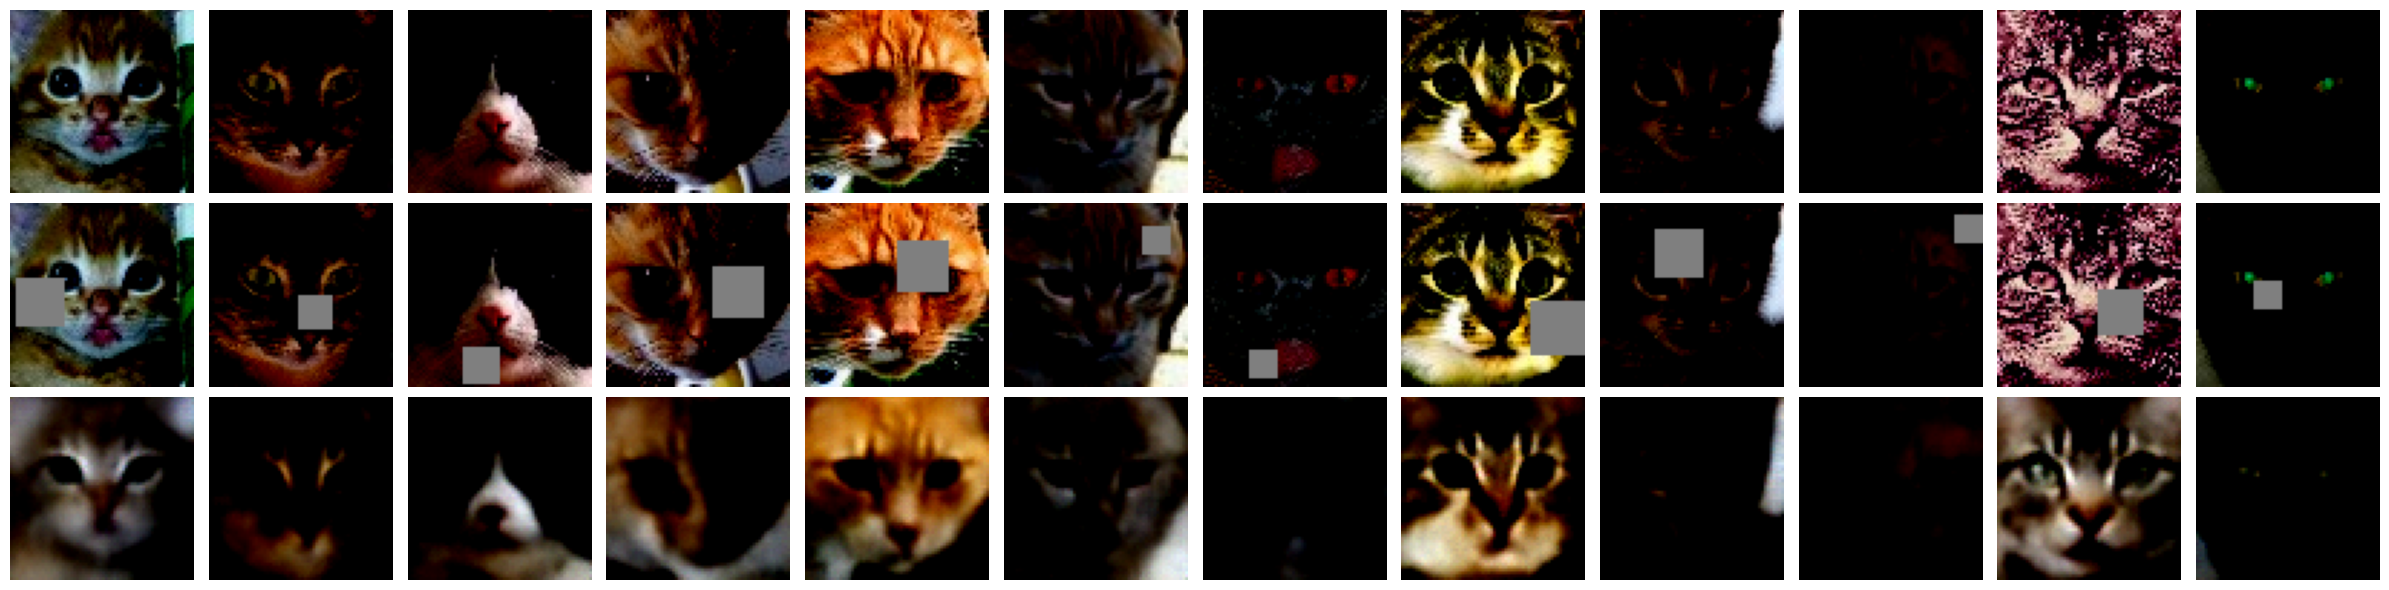

In [3]:
mask_img, clean_img = next(iter(test_dataloader))
mask_imgs = mask_img.to(device)
original_imgs = clean_img.to(device)

with torch.no_grad():
    reconstructed = model(mask_imgs)

show_images(original_imgs, mask_imgs, reconstructed["recon"], n=12)

#### 4.1.2 Wyniki VQ-VAE

Model VQ-VAE został wytrenowany dla różnych wartości hiperparametrów za pomocą grid seach:
- `num_residual_layers`: [1, 2],
- `num_embeddings`: [32, 64, 128],
- `embedding_dim`: [32, 64, 128],

stałymi hiperparametrami były:
- `batch_size`: 256
- `learning_rate`: 0.001
- `weight_decay`: 0.0001
- `epochs`: 30
- `mask_size`: 0.35

po uruchomieniu skryptu `src\scripts\reconstruction\run_vqvae_training.py` otrzymano 18 modeli VQVAE oraz wykresy.

Dla 4 najlepszych modeli VQ-VAE uzyskano następujące wyniki

<div style="display: flex; justify-content: space-around; align-items: flex-start;">

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vqvae/vqvae_layers2_ne32_ed32_metrics.png" width="400"/>
    <p>VQVAE layers=2 num_enc=32 enc_dim=32</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vqvae/vqvae_layers2_ne32_ed64_metrics.png" width="400"/>
    <p>VQVAE layers=2 num_enc=32 enc_dim=64</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vqvae/vqvae_layers2_ne64_ed32_metrics.png" width="400"/>
    <p>VQVAE layers=2 num_enc=644 enc_dim=32</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vqvae/vqvae_layers2_ne64_ed64_metrics.png" width="400"/>
    <p>VQVAE layers=2 num_enc=64 enc_dim=64</p>
  </div>


</div>


| Model                                       | Final Validation Loss | Perplexity | 
|---------------------------------------------|-----------------------|------------|
| VQVAE (layers=2, num_enc=32 enc_dim=32)     | 0.03836               | 22.5       |
| VQVAE (layers=2, num_enc=32 enc_dim=64)     | 0.03752               | 21.1       |
| VQVAE (layers=2, num_enc=64 enc_dim=32)     | 0.03640               | 24.4       |
| VQVAE (layers=2, num_enc=64 enc_dim=64)     | 0.04611               | 21.3       |
 

Wyniki ukazują, iż dla niższych wartości liczby wektorów w coebook występują lepsze rezultaty.

Mimo tego, że modele posiadają dostępne 32 oraz 64 wektory, to w trakcie treningu wykorzystują zaledwie 20-25% z nich, co sugeruje, że model nie jest w stanie wykorzystać pełnej mocy codebooku.

Najlepiej wypadającym modelem z tej grupy okazał się model o `num_enc=64` i `enc_dim=64` na którym zostanie przeprowadzony test.

Model został ten przetrenowany ponownie dla tych hiperparametrów na 80 epokach, aby uzyskać lepsze wyniki.

In [ ]:
from src.models.vqvae.vqvae import VQVAE

model = VQVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    num_embeddings=256,
    embedding_dim=64,
    commitment_cost=0.25,
    device=device
)

model.load_state_dict(
    torch.load("models/reconstruction/vqvae/vqvae_layers2_ne256_ed64.pt", map_location=device)
)

evaluate_model(model, test_dataloader, device)

Test MSE: 0.0054
Test SSIM: 0.7194
Test PSNR: 23.4073


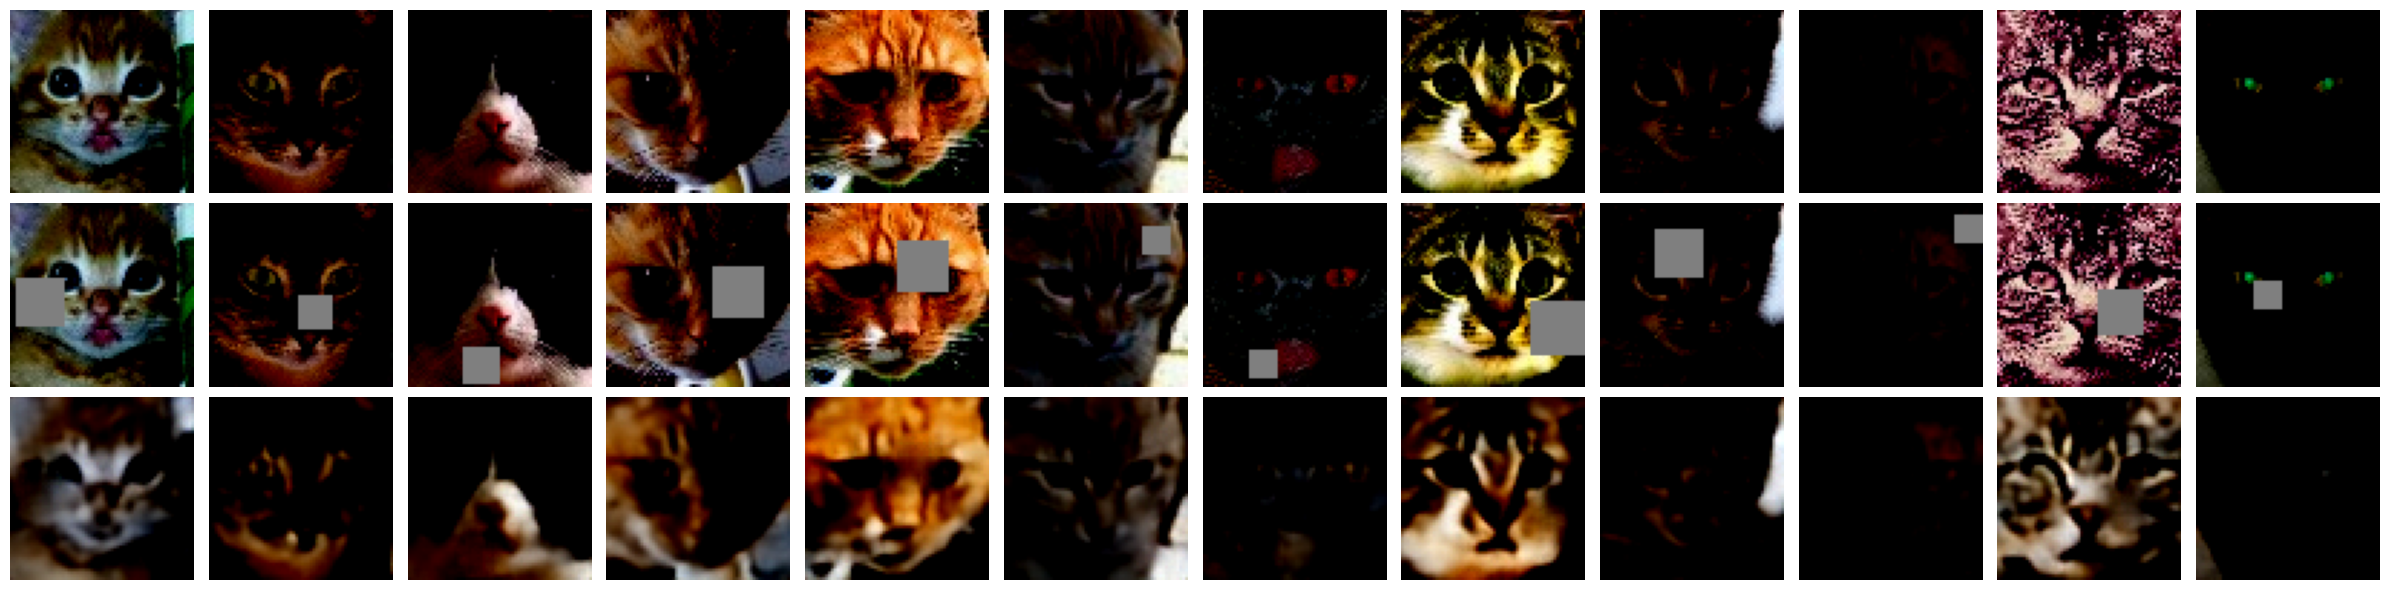

In [5]:
with torch.no_grad():
    reconstructed = model(mask_imgs)

show_images(original_imgs, mask_imgs, reconstructed["recon"], n=12)

#### 4.1.3 Wyniki VAE + Tree VI

### TODO Nikodem
Pamiętać o napisaniu Badane hiperparametry modeli i metod

#### 4.1.4 Wyniki A-VAE / VAE-GAN

### TODO Daniel
Pamiętać o napisaniu Badane hiperparametry modeli i metod

### 4.2 Część Self Supervised Learning + VAE

#### 4.2.1 Wyniki BYOL oraz BYOL + VAE

Model BYOL został wytrenowana dla różnych wartości hiperparametrów za pomocą grid search:
- `num_residual_layers`: [1, 2]
- `mlp_hidden_dim`: [512, 1024, 2048]
- `mask_size_ratio`: [0.0, 0.35]
- `tau`: [0.95, 0.97, 0.99, 0.999]

Ciekawym dodatkiem do klasycznej augmentacji BYOL, którą można znaleźć w pliku `src\models\byol\BYOLViewGenerator.py` jest augmentacja w postaci **maskowania obrazu**, która jest realizowana poprzez losowe nakładanie masek o losowych rozmiarach w losowych miejscach dla jednego z obrazów. Maski są generowane na podstawie wartości `mask_size_ratio`, która określa stosunek powierzchni maski do powierzchni obrazu.

Do pozostałych użytych augmentacji należą:
- RandomResizedCrop
- RandomHorizontalFlip
- ColorJitter
- GaussianBlur

stałymi hiperparametrami były:
- `lr`: 1e-4
- `weight_decay`: 1e-4
- `epochs`: 30

### **Po wytrenowaniu modeli BYOL wycięto z nich enkodery oraz zamrożono ich wagi. Następnie enkodery zostały podpięte do klasycznego VAE, który został wytrenowany na tych samych hiperparametrach co w przypadku klasycznego VAE.**

W celu zbadania wystąpienia zapadnięcia latent space przeprowadzono wizualizację przestrzeni latentnej dla ostatniej epoki traningudla 500 zdjęć z val dataset, dzięki czemu można zobaczyć, czy reprezentacje są rozproszone i czy nie występują zapadnięcia.

Dla 4 najlepszych modeli BYOL uzyskano następujące wyniki

<div style="display: flex; justify-content: space-around; align-items: flex-start;">

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/ssl/byol/byol_l1_mlp2048_mask00_tau099_tsne.png" width="500"/>
    <p>BYOL layers=1 mlp=2048 mask=0 tau=0.99</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/ssl/byol/byol_l2_mlp1024_mask00_tau097_tsne.png" width="500"/>
    <p>BYOL layers=2 mlp=1024 mask=0 tau=0.97</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/ssl/byol/byol_l1_mlp1024_mask035_tau097_tsne.png" width="500"/>
    <p>BYOL layers=1 mlp=1024 mask=0.35 tau=0.97</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/ssl/byol/byol_l2_mlp512_mask035_tau099_tsne.png" width="500"/>
    <p>BYOL layers=2 mlp=512 mask=0.35 tau=0.99</p>
  </div>

</div>


Można zaobserwować, iż eksperymenty nie wywołały zapadnięcia latent space.

Enkodery wyszkolone z augmentacją maskującą (mask_size_ratio=0.35, dwa po prawej)ukazują  rozkład równomierny w kształcie serca, bez wiekszych klastrów. 

Dla modeli bez augmentacji maskującej (mask_size_ratio=0.0, dwa po lewej) można zauważyć, że reprezentacje są równomiernie rozłożone w kształcie okręgu.

| Model                                       | Loss            
|---------------------------------------------|-----------------
|byol_l1_mlp512_mask00_tau095                 | 0.0634
|byol_l1_mlp512_mask00_tau097                 | 0.0689
|byol_l1_mlp512_mask00_tau099                 | 0.0734
|byol_l1_mlp512_mask00_tau0999                | 0.0832
|byol_l1_mlp512_mask035_tau095                | 0.0744
|byol_l1_mlp512_mask035_tau097                | 0.0716
|byol_l1_mlp512_mask035_tau099                | 0.0776
|byol_l1_mlp512_mask035_tau0999               | 0.1258
|byol_l1_mlp1024_mask00_tau095                | 0.0699
|byol_l1_mlp1024_mask00_tau097                | 0.0727
|byol_l1_mlp1024_mask00_tau099                | 0.0729
|byol_l1_mlp1024_mask00_tau0999               | 0.0999
|byol_l1_mlp1024_mask035_tau095               | 0.0716
|byol_l1_mlp1024_mask035_tau097               | 0.0676
|byol_l1_mlp1024_mask035_tau099               | 0.0680
|byol_l1_mlp1024_mask035_tau099               | 0.1160
|byol_l1_mlp2048_mask00_tau095                | 0.0720
|byol_l1_mlp2048_mask00_tau097                | 0.0729
|byol_l1_mlp2048_mask00_tau099                | 0.0658
|byol_l1_mlp2048_mask00_tau0999               | 0.0934
|byol_l1_mlp2048_mask035_tau095               | 0.0780
|byol_l1_mlp2048_mask035_tau097               | 0.0780
|byol_l1_mlp2048_mask035_tau099               | 0.0730
|byol_l1_mlp2048_mask035_tau099               | 0.1214
|byol_l2_mlp512_mask00_tau095_                | 0.0774
|byol_l2_mlp512_mask00_tau097                 | 0.0689
|byol_l2_mlp512_mask00_tau099                 | 0.6977
|byol_l2_mlp512_mask00_tau0999                | 0.0869
|byol_l2_mlp512_mask035_tau095                | 0.0791
|byol_l2_mlp512_mask035_tau097                | 0.0683
|byol_l2_mlp512_mask035_tau099                | 0.0647
|byol_l2_mlp512_mask035_tau0999               | 0.1038
|byol_l2_mlp1024_mask00_tau095                | 0.0706
|byol_l2_mlp1024_mask00_tau097                | 0.0645
|byol_l2_mlp1024_mask00_tau099                | 0.0663
|byol_l2_mlp1024_mask00_tau0999               | 0.0931
|byol_l2_mlp1024_mask035_tau095               | 0.0702
|byol_l2_mlp1024_mask035_tau097               | 0.0693
|byol_l2_mlp1024_mask035_tau099               | 0.0685
|byol_l2_mlp1024_mask035_tau0999              | 0.1183
|byol_l2_mlp2048_mask00_tau095                | 0.0739
|byol_l2_mlp2048_mask00_tau097                | 0.0726
|byol_l2_mlp2048_mask00_tau099                | 0.0670
|byol_l2_mlp2048_mask00_tau0999               | 0.1072
|byol_l2_mlp2048_mask035_tau095               | 0.0776
|byol_l2_mlp2048_mask035_tau097               | 0.0764
|byol_l2_mlp2048_mask035_tau099               | 0.0721
|byol_l2_mlp2048_mask035_tau0999              | 0.0130

Analizując krótko wpływ hiperparametrów na wyniki modeli BYOL można zauważyć:

- **tau**: niższe wartości (`0.95` oraz `0.999`) obniżają loss,z nacznie lepsze wyniki dla `0.99` i `0.97`.
- **mlp size**: większe wartości (`1024`, `2048`) zazwyczaj poprawiają loss, zwłaszcza przy niższym niskim `tau`.
- **mask ratio**: mask ratio zdecydowanie zwiększa loss, ale jest to spodziewane, ponieważ dodajemy trudną augmentację. Mimo gorszych wyników loss, maskowanie może poprawić skuteczność rekonstruckji dla VAE.


Zdecydowano się wytrenować VAE dla 4 zestawów hiperparametrów BYOL
- BYOL layers=1 mlp=2048 mask=0 tau=0.99
- BYOL layers=1 mlp=1024 mask=0.35 tau=0.97
- BYOL layers=2 mlp=512 mask=0.35 tau=0.99
- BYOL layers=2 mlp=1024 mask=0 tau=0.97

Dla hiperparametrów
- `input_dim`: 3,
- `hidden_dim`: 128,
- `residual_hiddens`: 64,
- `lr`: 1e-3,
- `weight_decay`: 1e-4,
- `epochs`: 50,
- `mask_size`: 0.35,
- `latent_dim`: 1024,

Dla 4 najlepszych modeli VAE+BYOL uzyskano następujące wyniki

<div style="display: flex; justify-content: space-around; align-items: flex-start;">

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae-byol/byol_vae_layers1_maskedBYOLFalse_latent1024_metrics.png" width="400"/>
    <p>VAE+BYOL layers=1 mlp=2048 mask=0 tau=0.99</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae-byol/byol_vae_layers1_maskedBYOLTrue_latent1024_metrics.png" width="400"/>
    <p>VAE+BYOL layers=1 mlp=1024 mask=0.35 tau=0.97</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae-byol/byol_vae_layers2_maskedBYOLTrue_latent1024_metrics.png" width="400"/>
    <p>VAE+BYOL layers=2 mlp=512 mask=0.35 tau=0.99</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="assets/models/reconstruction/vae-byol/byol_vae_layers2_maskedBYOLFalse_latent1024_metrics.png" width="400"/>
    <p>VAE+BYOL layers=2 mlp=1024 mask=0 tau=0.97</p>
  </div>

</div>


| Model                               | Final Validation Loss | Final Active Dimensions |
|-------------------------------------|-----------------------|-------------------------|
| VAE+BYOL layers=1 mlp=2048 mask=0 tau=0.99     | 159880             | 970.5                    |
| VAE+BYOL layers=1 mlp=1024 mask=0.35 tau=0.97      | 154783             | 912                     |
| VAE+BYOL layers=2 mlp=512 mask=0.35 tau=0.99     | 159624               | 944                     |
| VAE+BYOL layers=2 mlp=1024 mask=0 tau=0.97      | 182534               | 1016                     |


porównując wyniki modeli VAE+BYOL z wynikami klasycznego VAE można zauważyć, że modele VAE+BYOL osiągają nieznacznie gorsze wyniki w zakresie funkcji straty. 

Może to wstępnie sugerować, że zamrożenie enkodera wstępnie wytrowanego w BYOL nie jest najlepszym rozwiązaniem.

#### VAE+BYOL layers=1 mlp=2048 mask=0 tau=0.99

In [6]:
model_l1_no_mask = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=1024,
)

model_l1_no_mask.load_state_dict(
    torch.load("models/reconstruction/vae-byol/byol_vae_layers1_maskedBYOLFalse_latent1024.pt", map_location=device)
)

evaluate_model(model_l1_no_mask, test_dataloader, device)

Test MSE: 0.0109
Test SSIM: 0.4842
Test PSNR: 20.0809


#### VAE+BYOL layers=1 mlp=1024 mask=0.35 tau=0.97

In [7]:
model_l1_mask = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=1024,
)

model_l1_mask.load_state_dict(
    torch.load("models/reconstruction/vae-byol/byol_vae_layers1_maskedBYOLTrue_latent1024.pt", map_location=device)
)

evaluate_model(model_l1_mask, test_dataloader, device)

Test MSE: 0.0109
Test SSIM: 0.4793
Test PSNR: 20.0630


#### VAE+BYOL layers=2 mlp=512 mask=0.35 tau=0.99

In [8]:
model_l2_no_mask = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=1024,
)

model_l2_no_mask.load_state_dict(
    torch.load("models/reconstruction/vae-byol/byol_vae_layers2_maskedBYOLFalse_latent1024.pt", map_location=device)
)

evaluate_model(model_l2_no_mask, test_dataloader, device)

Test MSE: 0.0123
Test SSIM: 0.4494
Test PSNR: 19.5151


#### VAE+BYOL layers=2 mlp=1024 mask=0 tau=0.97

In [9]:
model_l2_mask = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=1024,
)

model_l2_mask.load_state_dict(
    torch.load("models/reconstruction/vae-byol/byol_vae_layers2_maskedBYOLTrue_latent1024.pt", map_location=device)
)

evaluate_model(model_l2_mask, test_dataloader, device)

Test MSE: 0.0112
Test SSIM: 0.4715
Test PSNR: 19.9602


#### dla najlepiej radzącego sobie modelu finetuned  VAE+BYOL layers=1 mlp=1024 mask=0.35 tau=0.97

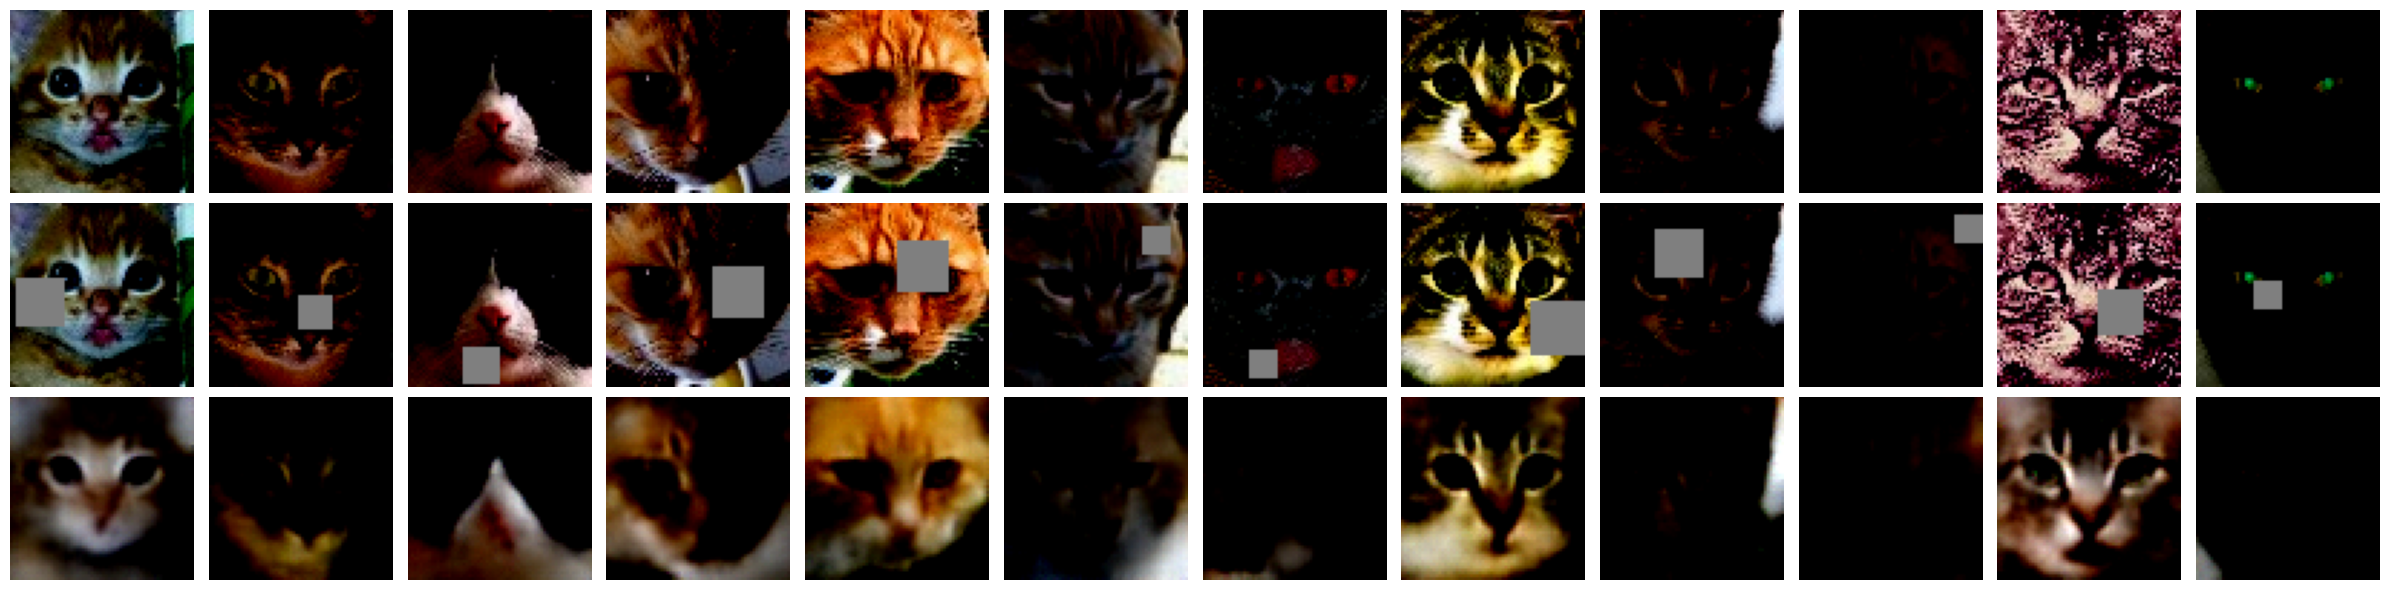

In [10]:
with torch.no_grad():
    reconstructed = model_l1_mask(mask_imgs)

show_images(original_imgs, mask_imgs, reconstructed["recon"], n=12)

#### 4.2.2 Wyniki Barlow Twins oraz Barlow Twins + VAE

Model Barlow Twins został wytrenowany dla różnych wartości hiperparametrów za pomocą grid search:
- `num_residual_layers`: [1, 2]
- `mlp_hidden_dim`: [512, 1024, 2048]
- `mask_size_ratio`: [0.0, 0.35]
- `lambda`: [0.001, 0.005, 0.01]

Tak samo jak przy augumentacji BYOL dodano augumentacje z i bez **maskowania obrazu**. 

Do pozostałych użytych augmentacji należą:
- RandomResizedCrop
- RandomHorizontalFlip
- ColorJitter
- GaussianBlur
- RandomSolarize

stałymi hiperparametrami były:
- `lr`: 1e-4
- `weight_decay`: 1e-4
- `epochs`: 30

### **Po wytrenowaniu modeli BYOL wycięto z nich enkodery oraz zamrożono ich wagi. Następnie enkodery zostały podpięte do klasycznego VAE, który został wytrenowany na tych samych hiperparametrach co w przypadku klasycznego VAE.**

W celu zbadania wystąpienia zapadnięcia latent space przeprowadzono wizualizację przestrzeni latentnej dla ostatniej epoki traningudla 500 zdjęć z val dataset, dzięki czemu można zobaczyć, czy reprezentacje są rozproszone i czy nie występują zapadnięcia.

Dla 4 najlepszych modeli Barlow Twins uzyskano następujące wyniki

<div style="display: flex; justify-content: space-around; align-items: flex-start;">

  <div style="text-align: center; margin: 10px;">
    <img src="models/ssl/byol/embeddings/byol_l1_mlp2048_mask00_tau099_tsne.png" width="500"/>
    <p>BYOL layers=1 mlp=2048 mask=0 tau=0.99</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="models/ssl/byol/embeddings/byol_l1_mlp1024_mask035_tau097_tsne.png" width="500"/>
    <p>BYOL layers=1 mlp=1024 mask=0.35 tau=0.97</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="models/ssl/byol/embeddings/byol_l2_mlp512_mask035_tau099_tsne.png" width="500"/>
    <p>BYOL layers=2 mlp=512 mask=0.35 tau=0.99</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="models/ssl/byol/embeddings/byol_l2_mlp1024_mask00_tau097_tsne.png" width="500"/>
    <p>BYOL layers=2 mlp=1024 mask=0 tau=0.97</p>
  </div>

</div>


#### 4.2.3 Wyniki SIM CLR oraz SIM CLR + VAE

### TODO Daniel
Pamiętać o napisaniu Badane hiperparametry modeli i metod

## 5. Wnioski

### 5.1 Podsumowanie wyników

tabelka z tymi wynikami takimi

- Test MSE: 0.0084
- Test SSIM: 0.5531
- Test PSNR: 21.2349 

co ma każdy model

## TODO Daniel
zrobić tabelkę z wynikami wszystkich modeli oraz interpretacje ssłowną, czy potwierdziliśmy hipoteze, co można zrobić lepiej itd.

SSL

| Model                               | SSL                  | Final Validation Loss | Final Active Dimensions % | MSE | SSIM | PSNR |
|-------------------------------------|-----------------------|-------------------------|---------------------|--|--|--|
| VAE (layers=2, latent_dim=512)     |-                     |137 267               | 98.24    | 0.0091  |0.5316| 20.9098            |
| VAE (layers=1, latent_dim=1024)|BYOL (tau=0.97, masked)|154 783|89.06|0.0109|0.4793|20.0630|
| VAE (layers=2, latent_dim=1024)|BYOL (tau=0.97, not masked)|182 534|99.22|0.0112|0.4715|19.9602|
| VAE (layers=2, latent_dim=1024)|BYOL (tau=0.99, masked)|159 624|92.19|0.0123|0.4494|19.5151|
| VAE (layers=1, latent_dim=1024)|BYOL (tau=0.99, not masked)|159 880|94.78|0.0109|0.4842|20.0809|

PGM

| Model                               | Final Active Dimensions % | MSE | SSIM | PSNR |
|-------------------------------------|-------------------------------------------|--|--|--|
| VAE (layers=2, latent_dim=512)     | 98.24    | 0.0091  |0.5316| 20.9098            |
| QVAE (layers=1, latent_dim=512)| 98.24 | 0.00564  |0.7194| 23.4073|
 
 

### 5.2 Analiza uzyskanych wyników w porównaniu z SOTA

## TODO Daniel
pokazać przykłądy najlepszych modeli do tego zadania (nie na naszym datasecie tylko z neta coś wziać) 